## 1. Exploratory Data Analysis 

In this project, we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features. 

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### 1.1. Visualising the data

When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

In this section, we aim to recreate a grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) show a distribution (or histogram) for that feature.    


In [2]:
import seaborn as sns


# define plotting function
def myplotGrid(X,y):
    
    #Convert to data frame and add target class
    df = pd.DataFrame(X, columns = selected_features)
    df['class'] = y
    
    #set up pair plot
    sns.pairplot(df,kind='scatter',diag_kind='kde', hue='class')
    plt.show() 
    

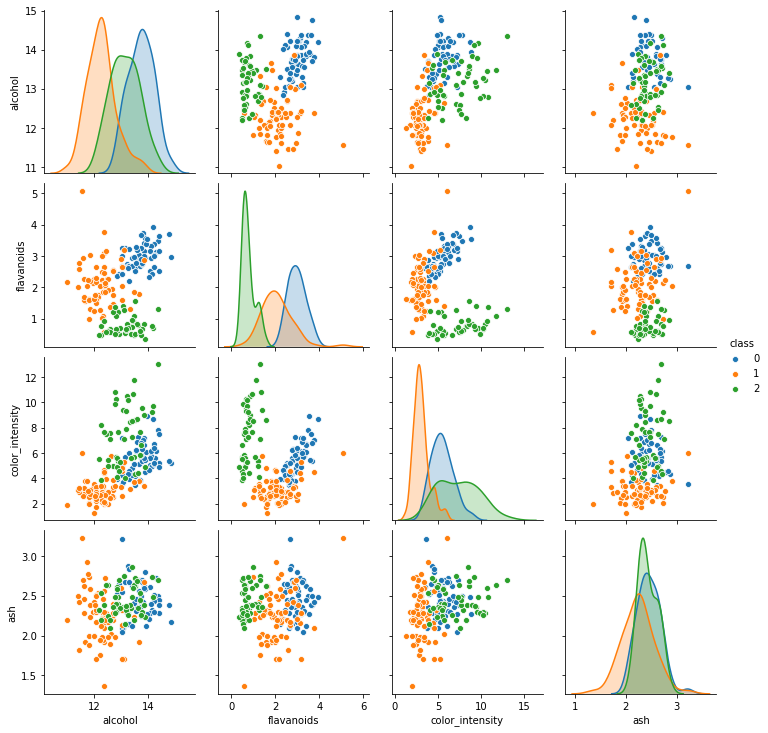

In [3]:
# run the plotting function
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, we conduct exploratory data analysis on a noisy version of data X.

We perturb the data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.6,X.shape)
    
and then invoke

    myplotGrid(XN,y)

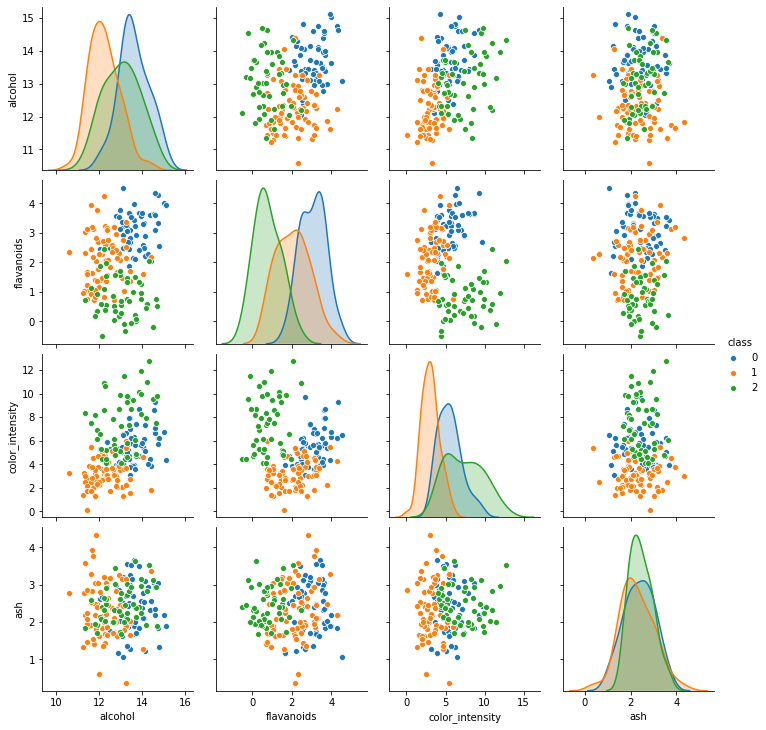

In [4]:
# noise code
mySeed = 12345
np.random.seed(mySeed)
XN = X + np.random.normal(0,0.6,X.shape)

#plot again
myplotGrid(XN,y)

## 2. Implementing kNN 

In the cell below, we use k-Nearest Neighbour to implement our classification model.


In [5]:
# helper code
from collections import Counter

#Manhattan Distance
def manhattan(v1, v2):
        '''Takes 2 vectors a, b and returns the manhattan distance'''
        return np.abs(np.array(v1) - np.array(v2)).sum()

#Euclidean Distance
def euclidean(v1, v2):
        '''Function to calculate Euclidean Distance'''       
        distance = 0.0
        for i in range(len(v1)-1):
            distance += (v1[i] - v2[i])**2
        return (distance)**0.5

#Function to calculate KNN
def mykNN(X, y , X_, k, dist_calc):
    output_labels = []
     
    #Loop through each data point
    for point in X_: 
         
        #Stores distances
        distances = []
         
        #Loop through each training data point
        for i in range(len(X)):
            if(dist_calc == 'euclidean'):
                dist = euclidean(np.array(X[i,:]) , point)
            elif (dist_calc == 'manhattan'):
                dist = manhattan(np.array(X[i,:]), point)
            else:
                raise ValueError("Invalid distance calculation method: {}".format(dist_calc))
            distances.append(dist) 
            
        #Convert into numpy array    
        distances = np.array(distances) 
         
        #Sort the array and keep k datapoints
        distances = np.argsort(distances)[:k] 
         
        #Labels of the K datapoints
        labels = y[distances]
        
        # counter object to track labels
        counter = Counter(labels)

        # Get most common label of all the nearest neighbors 
        label = counter.most_common()[0][0] 
        output_labels.append(label)
 
    return output_labels

In [6]:
# mykNN code
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# normalize the data
normalized_X = preprocessing.normalize(X)


#Split train/test data
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.33, random_state=42)

#Applying our function with k = 7
y_ = mykNN(X_train,y_train,X_test , 7, 'euclidean')

## 3. Classifier evaluation 


In [7]:
# confusion matrix, accuracy, precision, recall, etc. 

def build_matrix(actual, predicted):
    #Convert to series
    y_actual = pd.Series(actual, name='Actual')
    y_predicted = pd.Series(predicted, name='Predicted')

    #build matrix
    return pd.crosstab(y_actual, y_predicted, rownames=['Actual'], colnames=['Predicted'])



# Function to calculate accuracy
def accuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return round(correct / float(len(actual)) * 100.0, 2)

#Function to give recall score tp/tp+fn
def recall(matrix):
    #true positive and false negative
    tp = np.diag(matrix)
    fn = np.sum(matrix, axis=1) - tp
    
    recall = np.sum(tp / (tp + fn))
    
    #recall percentage
    return round(recall/len(matrix)*100,2)
    

def precision(matrix):
    tp = np.diag(matrix)
    fp = np.sum(matrix, axis=0) - tp
    
    precision = np.sum(tp / (tp + fp))
    
    #precision percentage
    return round(precision/len(matrix)*100,2)
            
    

#Print cf matrix
print(build_matrix(y_test, y_))

Predicted   0   1   2
Actual               
0          19   1   0
1           5  19   0
2           0   0  15


In [9]:
# test evaluation code
cf_matrix = build_matrix(y_test, y_)
accuracy_score = accuracy(y_test,y_)
recall_score = recall(cf_matrix)
precision_score = precision(cf_matrix)

print("The KNN returned an accuracy score of {}%".format(accuracy_score))
print("The KNN returned a recall score of {}%".format(recall_score))
print("The KNN returned a precision score of {}%".format(precision_score))

The KNN returned an accuracy score of 89.83%
The KNN returned a recall score of 91.39%
The KNN returned a precision score of 91.39%



## 4. Nested Cross-validation  

We perform a 5-fold nested cross-validation along with our implemenation of k-NN above.


In [10]:
# myNestedCrossVal code
from sklearn.model_selection import KFold

def GetAccuracy(y_p, y_t):
    #Convert to series
    y_actual = pd.Series(y_t, name='Actual')
    y_predicted = pd.Series(y_p, name='Predicted')

    return accuracy(y_actual, y_predicted)

def findBestScores(scores):
    highest_score = 0
    best_index = 0
    for index in range(len(scores)):
        if(scores[index][2] > highest_score):
            highest_score = scores[index][2]
            best_index = index
    
    return scores[best_index]

def myNestedCrossVal(X,y,n_folds,n_neighbours,distances,mySeed, cm=False):
    '''n-fold nested cross-validation for k-NN '''
     
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=n_folds, shuffle=True, random_state=mySeed)
    cv_inner = KFold(n_splits=n_folds, shuffle=True, random_state=mySeed)
    
    
    #outer loop
    i = 0;
    outer_scores = []
    y_pred_summary = []
    y_test_summary = []
    for j, k in cv_outer.split(X):
        
        #i represents current outer fold
        i = i + 1
        
        # split data
        X_train, X_test = X[j,:], X[k,:]
        y_train, y_test = y[j], y[k]
        
        inner_scores = []        
        for l, m in cv_inner.split(X_train):
           
            Xj_train, X_eval = X_train[l,:], X_train[m,:]
            yj_train, y_eval = y_train[l], y_train[m]
            
            #hyperparameter tunning
            for distance in distances:
                for neighbour in n_neighbours:
                    y_pred = mykNN(Xj_train,yj_train,X_eval, neighbour, distance)
                    accuracy = GetAccuracy(y_pred,y_eval)
                    inner_scores.append([distance, neighbour, accuracy])
         
        #Outer validation
        best_scores = findBestScores(inner_scores)
        y_pred_fold = mykNN(X_train,y_train,X_test, best_scores[1], best_scores[0])
        accuracy_fold = GetAccuracy(y_pred_fold,y_test)
        
        #append prediction values and scores to their respective arrays
        y_pred_summary.extend(y_pred_fold)
        y_test_summary.extend(y_test)
        outer_scores.append([i, accuracy_fold, best_scores[1], best_scores[0]])
    
    
    #result for scores
    result = pd.DataFrame(np.array(outer_scores),columns=['fold', 'accuracy', 'k', 'distance'])
    result['accuracy'] = result['accuracy'].astype(float)
    
    #result as a confusion matrix
    if(cm == True):
        print(build_matrix(y_test_summary,y_pred_summary), '\n')

    return result

In [11]:
# evaluate clean data code
accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],42)

In [12]:
# evaluate noisy  data code
accuracies_fold_noise = myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean','manhattan'],42)

In [13]:
# Print the summaries
print(accuracies_fold.head(), '\n')
print(round(accuracies_fold['accuracy'].mean(),2), round(accuracies_fold['accuracy'].std(),2))
print(accuracies_fold_noise.head())
print(round(accuracies_fold_noise['accuracy'].mean(),2), round(accuracies_fold_noise['accuracy'].std(),2))

  fold  accuracy  k   distance
0    1     97.22  1  euclidean
1    2     94.44  1  euclidean
2    3     88.89  3  euclidean
3    4     97.14  1  euclidean
4    5     94.29  1  euclidean 

94.4 3.39
  fold  accuracy  k   distance
0    1     88.89  3  euclidean
1    2     83.33  4  euclidean
2    3     77.78  3  euclidean
3    4     91.43  3  euclidean
4    5     97.14  3  euclidean
87.71 7.45


### 5.2. Confusion matrix summary

We use two summary confusion matrices to summarize the results of our nested cross-validation (one for the noisy data, one for the clean data). 


In [14]:
print('CLEAN')
# clean data summary results
clean = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],42, True)




print('NOISY')
# clean data summary results
noisy = myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean','manhattan'],42, True)

CLEAN
Predicted   0   1   2
Actual               
0          58   1   0
1           6  64   1
2           0   2  46 

NOISY
Predicted   0   1   2
Actual               
0          51   7   1
1           5  62   4
2           0   5  43 

